# 链接仪器

In [1]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)

In [2]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
#ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
#psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

# qubit工作点

In [3]:
f_cavity = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9

atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=0,f_ex=2*6.3e9+2e6,power_ex=-5) #power=-2.1

In [33]:
q1 = q1._replace(f_lo=np.array([6.505e9]))

In [5]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=-0.15, zpulse=None, f_lo=array([6.50484e+09]), delta=array([50000000.]), f_ex=array([3.77766345e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=28.0, T1=23016.178849233776)

## 保存工作点

In [119]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0319\QubitState\qubitstate_20200319163740.npz


## 提取工作点

In [4]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0319\QubitState\qubitstate_20200319163740.npz


# 指定仪器

In [5]:
psg_lo = psg104
psg_ex1 = psg105
psg_ex2 = psg106
psg_ex3 = psg230
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg134,'awg134':awg133,'awgread':awg134}

## 测量类

In [6]:
measure = mr.common(f_cavity,ats,dc,psg,awg_list,jpa)

In [54]:
measure.awg = awg_list

In [44]:
await mr.awgSync(measure)

# 信号检查

In [10]:
await mr.modulation_read(measure,np.array([50e6]),tdelay=1500)
await mr.ats_setup(ats,np.array([50e6]),l=1500)
await awg134.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [408]:
await ats.getValue('n')

1024

## 复平面信号

<IPython.core.display.Javascript object>


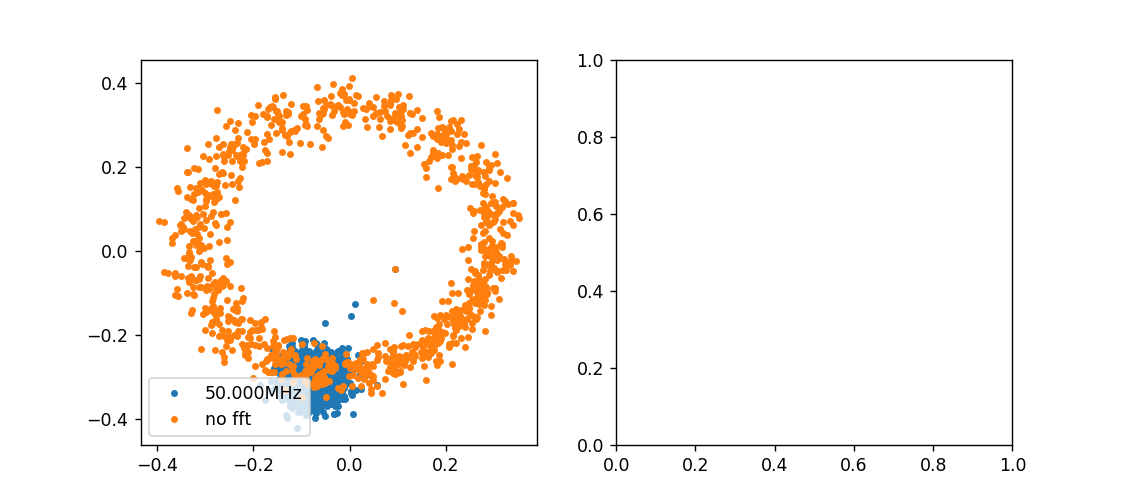

In [103]:
%matplotlib notebook
I, Q = 0, 0
await psg_lo.setValue('Output','ON')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=True,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

<IPython.core.display.Javascript object>


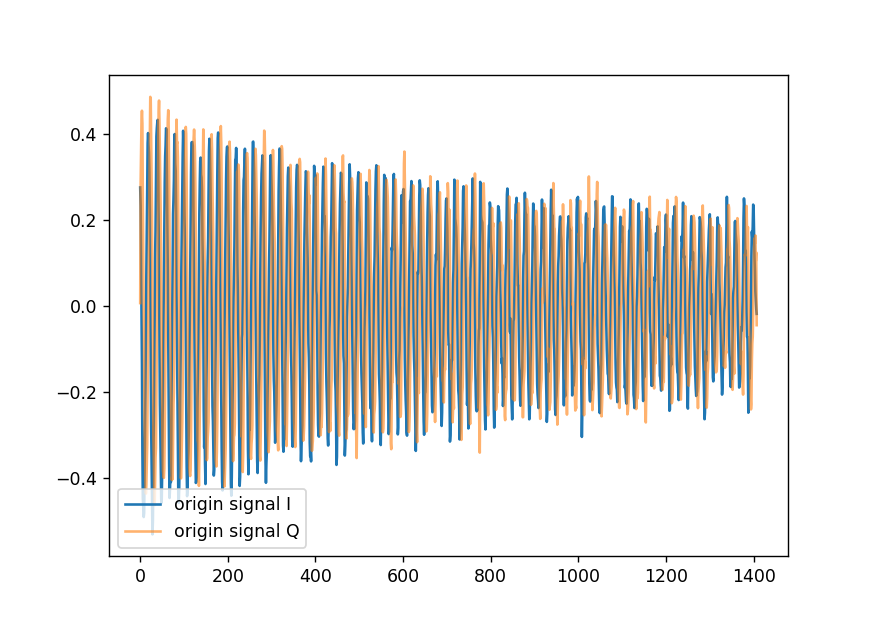

In [8]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex2'].setValue('Output','OFF')
for i in range(1):
    chA, chB = await ats.getTraces()
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


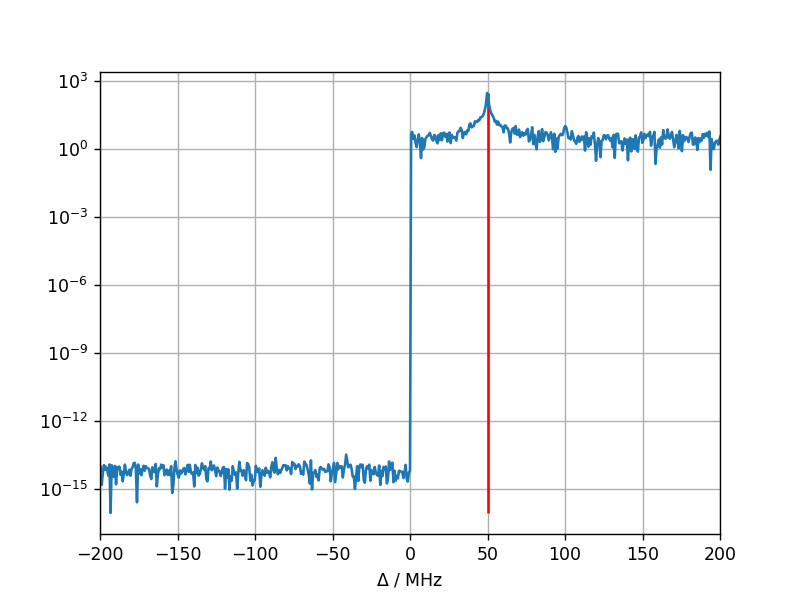

In [9]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1.e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-200,200)
plt.show()

# 仪器状态

In [8]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=['awg131','awg132','awg133','awg134'])

In [9]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.554840GHz,3.857663GHz,3.778344GHz,4.000000GHz,12.602000GHz
load,high Z,high Z,50.0,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0
offset,0,0,0.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,0.000000dBm,15.000000dBm,10.000000dBm,-5.000000dBm


In [82]:
await mr.RecoverInst(measure)

In [108]:
await dc06.setValue('Load','High')

In [26]:
q2

qubit(q_name='q2', inst={'dc': 'dc01', 'z_awg': 'awg131', 'z_ch': 2, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.77, 0.036], specfunc=2.4206879784596 - 1.48850724075543*cos(0.684392433401964*pi*x + 3.07515705750169), bias=-0.17, zpulse=None, f_lo=array([6.51788e+09]), delta=array([50000000.]), f_ex=array([3.777e+09]), delta_ex=array([0]), power_ex=10, power_rabi=10, pi_len=21.0, T1=50219.03244591381)

# S21

In [123]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 13.0


Output()

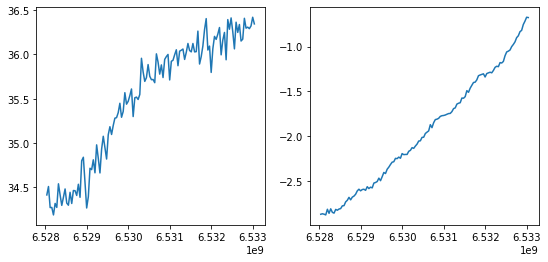

In [48]:
q_target = q3
tag = q_target.q_name
att_setup = mr.Att_Setup('com7')
att_setup.Att(13)
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
await mr.jpa_switch(measure,state='ON')
job = Job(mr.S21, (q_target,measure,True), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

In [49]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex1', 'com': 'com12'}, T_bias=[1.759, 0.068], specfunc=2.98687262994144 - 1.02629868128547*cos(0.876727600819897*pi*x + 2.96607490692315), bias=-0.19, zpulse=None, f_lo=array([6.53054e+09]), delta=array([50000000.]), f_ex=array([3.77965363e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=40.0, T1=23016.178849233776)

# S21vsFlux

In [106]:
current = np.linspace(-2,2,21)
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
#await dc[bis[0].inst['dc']].DC(1)
for i in bits:
    tag = i.q_name
    await mr.jpa_switch(measure,'ON')
    await awg134.output_on(ch=7)
    await awg134.output_on(ch=8)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux, (qubits,measure,current,True), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

# S21vsPower

In [26]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

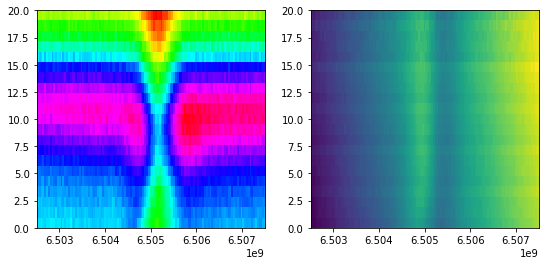

In [27]:
q_target, att = qubits, np.linspace(0,20,21)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com7'), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto',cmap='hsv')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [10]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=-0.15, zpulse=None, f_lo=array([6.50484e+09]), delta=array([50000000.]), f_ex=array([3.77766345e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=28.0, T1=23016.178849233776)

In [11]:
x = sy.Symbol('x')
q_target = q1
att_single, bias = q_target.power_ex, -0.15
#f_com = 3.736
f_com = np.float(q_target.specfunc.evalf(subs={x:bias}))
round(f_com,3)

3.773

com11 open...
DS Instruments,DAT64H,374,V9.10
ATT 25.0


Output()

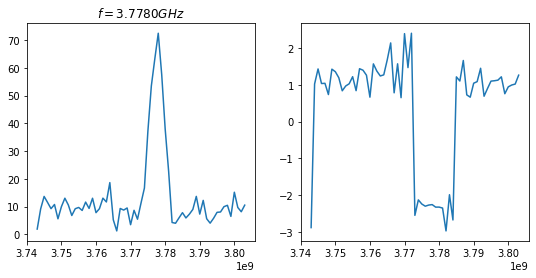

In [12]:
tag, freq = q_target.q_name, np.arange(-30,31,1)*1e6+round(f_com,3)*1e9
await dc[q_target.inst['dc']].DC(bias)
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex+10)
#await psg[q_target.inst['ex_lo']].setValue('Power',0)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True), tags=[tag], max=len(freq))
f_ss, s_ss = await job.done()
index = np.abs(s_ss).argmax(axis=0)
f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss,np.abs(s_ss))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(f_ss,np.angle(s_ss))
plt.show()

In [107]:
q7 = q7._replace(bias=bias,f_ex=f_rabi,f_lo=(measure.f_lo-measure.delta))

In [254]:
q7 = q7._replace(inst={'dc': 'dc08', 'z_awg': 'awg131', 'z_ch': 7, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex2', 'com': 'com8'},delta_ex=np.array([0]),power_ex=10)

In [17]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=-0.15, zpulse=None, f_lo=array([6.50484e+09]), delta=array([50000000.]), f_ex=array([3.77766345e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=28.0, T1=23016.178849233776)

# Rabi

In [108]:
q_target = q7
if q_target.inst['ex_lo'] == 'psg_ex2':
    t_rabi = np.linspace(3,103,101)
    att_single = 10
else:
    t_rabi = np.linspace(1,101,101)
    att_single = 25
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

com8 open...
DS Instruments,DAT64H,391,V9.10
ATT 20.0


Output()

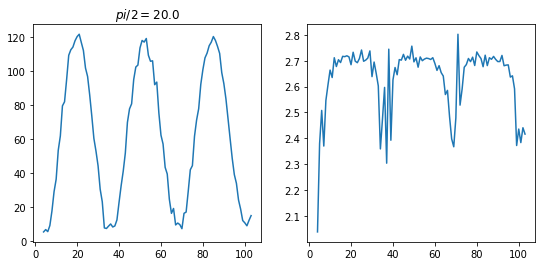

In [109]:

tag = q_target.q_name
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(att_single)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex[0]))
job = Job(mr.rabi, (q_target,measure,t_rabi,(len(t_rabi)-1),True), tags=[tag], max=500,avg=True)
t_r, s_r = await job.done()
# index = np.abs(s_r).argmax(axis=0)
# t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op = op.RowToRipe().firstMax(t_r[:,0],np.abs(s_r[:,0]),num=0)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(t_r,np.angle(s_r))
plt.show()

In [14]:
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op

array([29.])

In [56]:
q4

qubit(q_name='q4', inst={'dc': 'dc11', 'z_awg': 'awg131', 'z_ch': 4, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.761, 0.06], specfunc=-9.52738711934855*cos(0.27159079154588*pi*x + 3.09357666310556) - 5.53101400633113, bias=-0.2, zpulse=None, f_lo=array([6.54368e+09]), delta=array([50000000.]), f_ex=array([3.77e+09]), delta_ex=array([0]), power_ex=8, power_rabi=10, pi_len=19.0, T1=26511.572081147293)

In [110]:
q7 = q7._replace(pi_len=t_op,power_rabi=att_single)

# Readout point

Output()

<IPython.core.display.Javascript object>


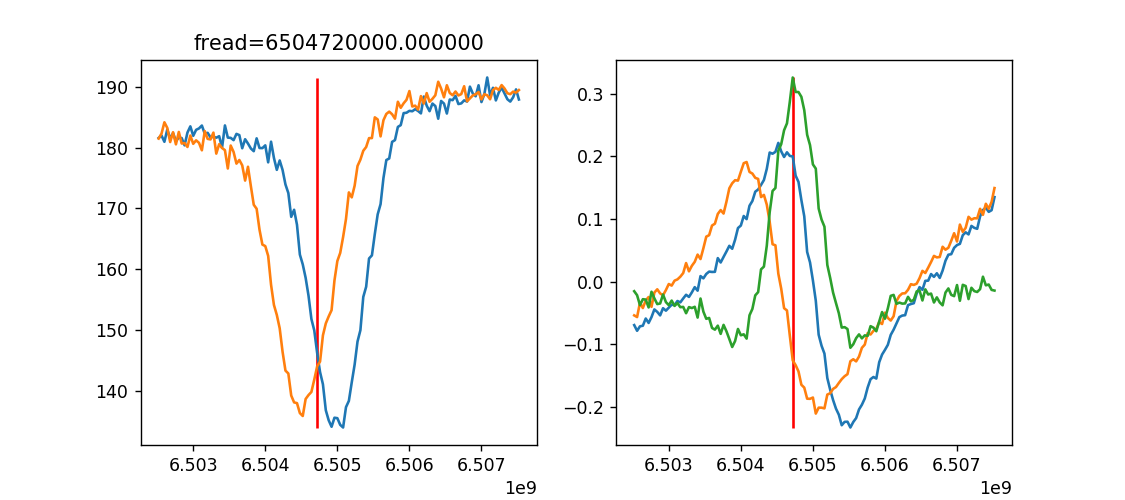

In [33]:
q_target = q1
job = Job(mr.readOp, (q_target,measure,True), tags=[tag], max=2)
st, f_op, s_op = await job.done()
f, s_off, s_on = f_op[:,:,0][0], s_op[:,:,0][0], s_op[:,:,0][1]
x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
index = np.abs(anglediff).argmax(axis=0)
#index = np.abs(s_off).argmin(axis=0)
f_lo = f[index]
measure.f_lo = np.array([f_lo])
await psg['psg_lo'].setValue('Frequency',(f_lo+measure.delta[0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_op[:,:,0].T,np.abs(s_op[:,:,0].T))
axes[0].set_title('fread=%f'%f_lo)
axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,0].T)),np.min(np.abs(s_op[:,:,0].T)),'r')
axes[1].plot(x_off,np.angle(y_off[0]))
axes[1].plot(x_on,np.angle(y_on[0]))
axes[1].plot(x_off,anglediff)
axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()

# 优化读出长度

In [145]:
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(9)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
# s_off, s_on = s_st[0][:,0], s_st[1][:,0]
# plt.figure()
# plt.plot(np.real(s_off),np.imag(s_off),'.')
# plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
# plt.axis('equal')
# plt.show()

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 09.0


Output()

<IPython.core.display.Javascript object>


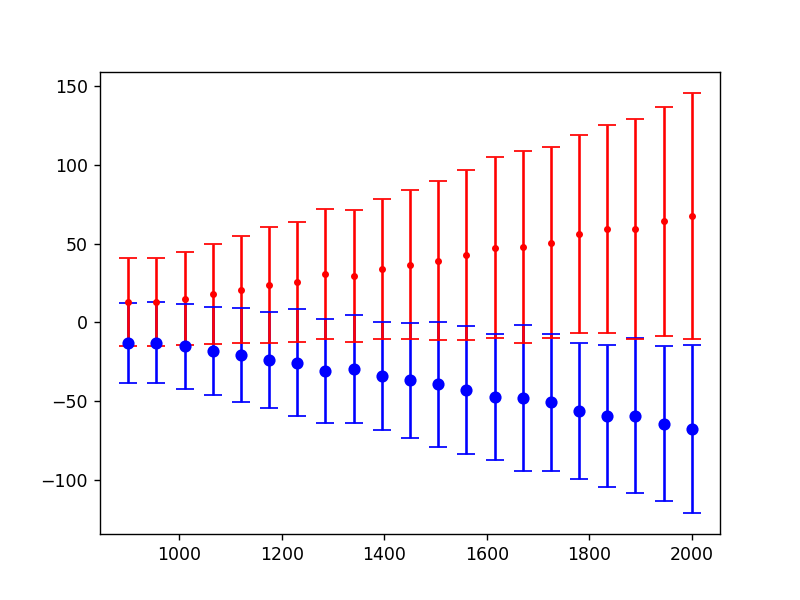

In [151]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 09.0


Output()

<IPython.core.display.Javascript object>


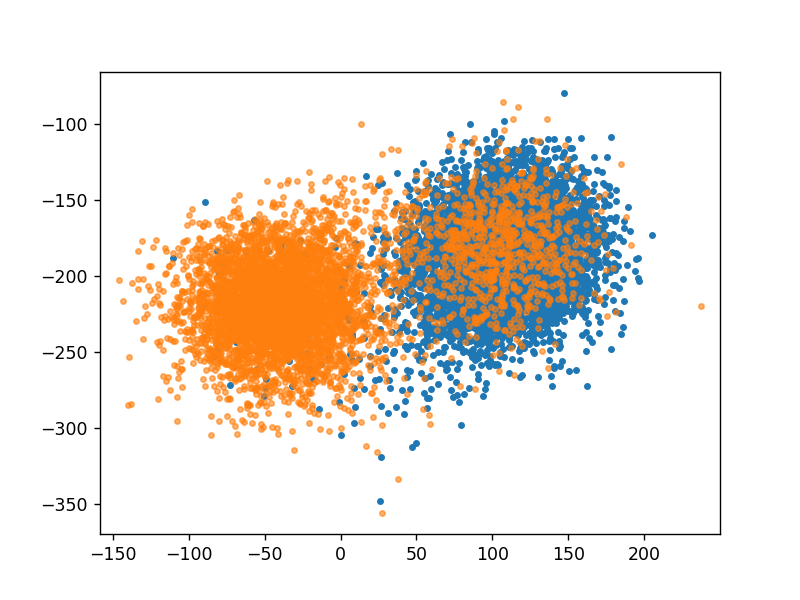

In [79]:
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(9)
job = Job(mr.threshHold, (q_target,measure), tags=[tag], max=2)
st, s_st = await job.done()
s_off, s_on = s_st[0][:,0], s_st[1][:,0]
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


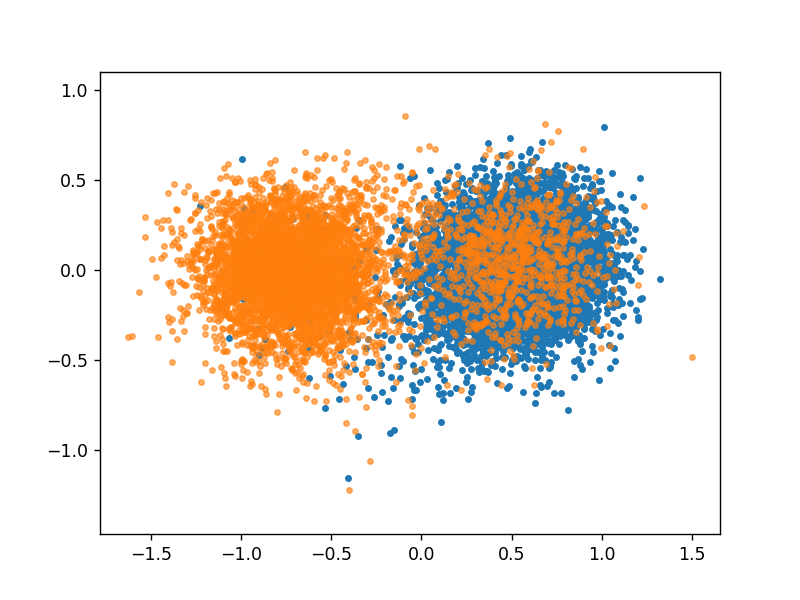

In [80]:
x, y = s_st[0][:,0], s_st[1][:,0]
add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
s_off, s_on = (x-add)/diff, (y-add)/diff
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

0.45243275316455694


<IPython.core.display.Javascript object>


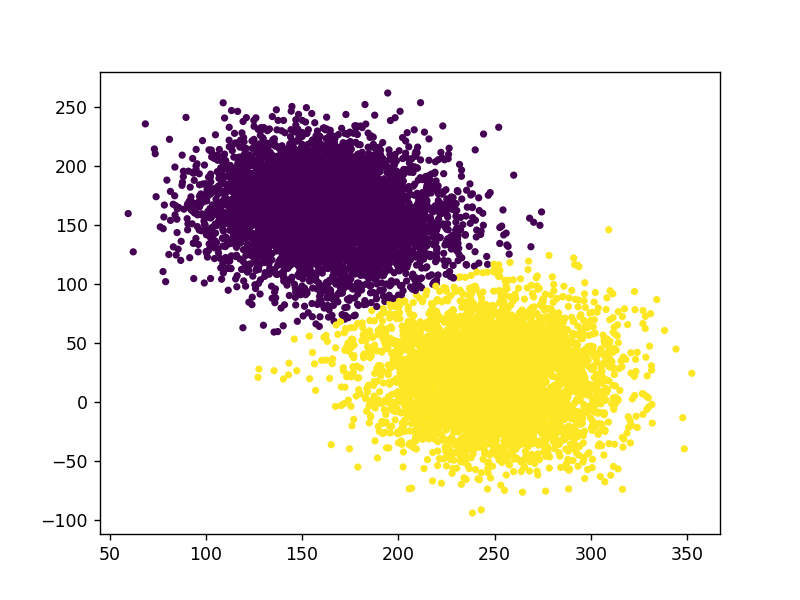

In [380]:
S = list(s_off) + list(s_on)
S = np.array(S)
x,z = np.real(S), np.imag(S)
d = list(zip(x,z))
d = np.mat(d)
kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
kmeans.fit(d)
measure.predict = kmeans.predict
y = kmeans.predict(d)
print(list(y).count(1)/len(y))
plt.figure()
plt.scatter(x,z,c=y,s=10)
plt.show()

0.9816060126582279


<IPython.core.display.Javascript object>


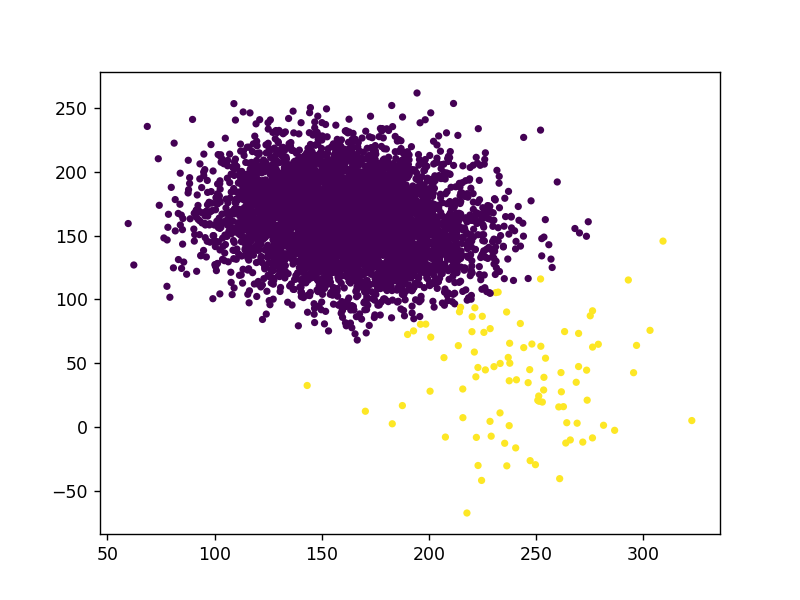

In [381]:
d = list(zip(np.real(s_off),np.imag(s_off)))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s_off),np.imag(s_off),c=y,s=10)
plt.show()

# AC-Stark

In [30]:
t_ac, q_target = np.linspace(-2000,500,501), q1
job = Job(mr.acStark, (q_target,measure,t_ac,(len(t_ac)-1),False), tags=[tag], max=61)
f_AC, t_AC, s_AC = await job.done()
# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC))
# plt.show()

Output()

In [24]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=0, zpulse=None, f_lo=[6505000000.0], delta=array([50000000.]), f_ex=array([3.757e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=27, T1=None)

# T1

Output()

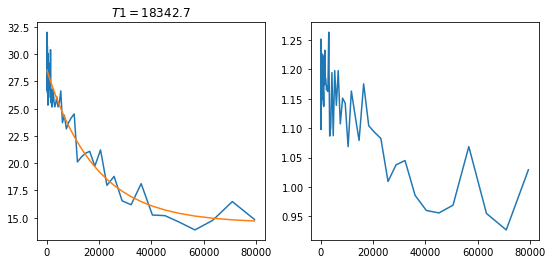

In [22]:
t_T1, q_target = np.logspace(0,4.9,101,endpoint=True), q1
await psg_ex1.setValue('Moutput','OFF')
job = Job(mr.T1, (q_target,measure,t_T1,(len(t_T1)-1),True), tags=[tag], max=500,avg=True)
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]/T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1f$'%T1)
axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [35]:
q1 = q1._replace(T1=T1)

# Ramsey

In [111]:
t_Ramsey, q_target = np.linspace(0,5000,101), q7
# if q_target.inst['ex_lo'] == 'psg_ex2':
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex+3e6)[0])

Output()

(51.32103543004125, 67.54704813129818, 20000, 1058.8310157813944, 0.0028000000000000004, 0)


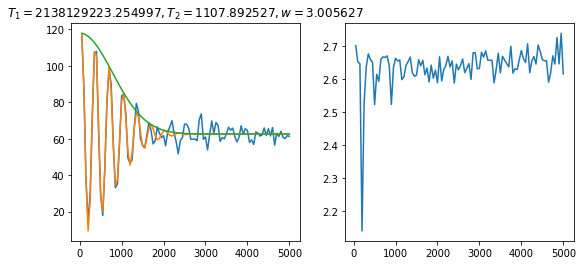

In [114]:
await psg_ex1.setValue('Moutput','ON')
job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,(len(t_Ramsey)-1),True), tags=[tag], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], s_ram[:,0]
A,B,T1,T2,w,phi = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(t_ram,np.angle(s_ram))
plt.show()

In [115]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [116]:
q7 = q7._replace(f_ex = (f-q_target.delta_ex-w*1e9+3e6))

In [84]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=-0.15, zpulse=None, f_lo=array([6.50484e+09]), delta=array([50000000.]), f_ex=array([3.77832565e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=28.0, T1=23016.178849233776)

# CrossTalk矫正

In [15]:
t_rabi = np.linspace(0,100,501)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [16]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

In [17]:
measure.n = 1

com11 open...
DS Instruments,DAT64H,374,V9.10
ATT 25.0


Output()

4.510162045707351 1.33220415106653 101.00000000000007 51.89750970581782


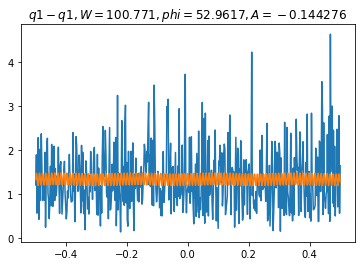

Output()

In [ ]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
for v,k in enumerate(bits[:1],start=0):
    q_target = k
    #await mr.jpa_switch(measure,'ON')
#     await measure.psg['psg_lo'].setValue('Frequency',(q_target.f_lo+q_target.delta)[0])
#     await measure.psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    #await dc[q_target.inst['dc']].DC(q_target.bias)
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.8e9:
                v_rabi = np.linspace(-1,1,501)
            else:
                v_rabi = np.linspace(-0.5,0.5,501)
        else:
            v_rabi = np.linspace(-1,1,501)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z_crosstalk[v,i] = W
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,A*np.cos(2*np.pi*W*v_Z+phi)+C)
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


# 二维谱

In [ ]:
freq = np.arange(3.45,4.05,0.001)*1e9
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
for i in [bits[2]]:
    att_setup = mr.Att_Setup(i.inst['com'])
    att_setup.Att(i.power_ex)
    await mr.jpa_switch(measure,'ON')
    await awg134.output_on(ch=7)
    await awg134.output_on(ch=8)
    print(i.q_name)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    job = Job(mr.spec2d, (qubits,measure,freq), tags=[i.q_name], max=31)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

# RB 

In [ ]:
mlist, q_target, len_data = np.logspace(0.4,2.5,21,dtype=int), q1, 31
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len_data,['Readout_Q']*len_data]

In [ ]:
job = Job(mr.RB, (q_target,measure,mlist,len_data,True), tags=[tag], max=len(mlist))
n_RB, s_RB = await job.done()

In [ ]:
pop = []
for j in range(np.shape(s_RB)[0]):
    s = np.array(s_RB[j])
    pm = []
    for i in range(np.shape(s)[1]):
        d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
        y = measure.predict(d)
        pm.append(list(y).count(0)/len(y))
    pop.append(pm)

In [ ]:
#n_RB = [1,5,10,20,50,100,150]
x = np.meshgrid(range(np.shape(pop)[1]),n_RB)[1]
%matplotlib notebook
plt.figure()
plt.plot(x.flatten(),np.array(pop).flatten(),'.')
plt.show()

In [ ]:
def err(paras,x,y):
    A,B,p = paras
    return A*p**x+B-y
def guess(x,y):
    B = np.min(y)
    y = y - np.min(y)
    mask = y > 0
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return np.exp(np.abs(a[1])), B, 1/np.exp(np.abs(a[0]))

In [ ]:
x, y = n_RB, np.abs(np.mean(pop,axis=1))
p0 = guess(x,y)
res = ls(err, p0, args=(x, y)) 
A,B,p = res.x
fig = plt.gcf()
ax = plt.getp(fig,'axes')
z = A*p**x+B
ax[0].plot(x,z)
ax[0].plot(x,y,'o')
ax[0].set_title('p=%f'%p)
plt.show()

In [ ]:
i = 20
s = np.array(s_RB[0])
d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s[:,i]),np.imag(s[:,i]),c=y,s=10)
plt.show()

<IPython.core.display.Javascript object>


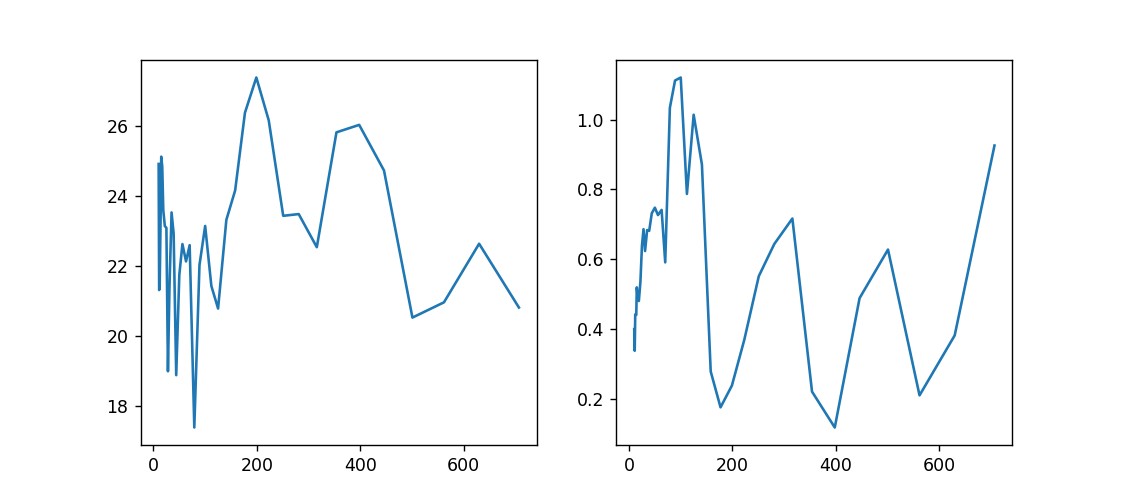

In [260]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(n_RB,np.abs(s_RB[:,:,0].mean(axis=1)))
axes[1].plot(n_RB,np.angle(s_RB[:,:,0].mean(axis=1)))
plt.show()